![rapids motivation](images/rapids_motivation.png)

![notebook choices](images/choices.png)


# Table of Contents

1. [ Generate a classification dataset on GPU ](#data-gen) (e.g., double helix, unwinding helix/whirl )

2. [ ETL - process/prepare data for model training ](#ETL) (e.g., scale, split, augment )
   > controllably breaking IID : non-identically distributed train and test data
    
3. [ Single model training ](#single-model)
   > CPUs vs 1 GPU
  - TODO summarize : accuracy (model predictions & errors viz), wall clocks, cleanup
  
4. [ Define HPO Strategy ](#define-hpo)

5. [ Scaling up within a node using Dask ](#scale-up-single-node-hpo)
   > LocalCUDACluster 
      
6. [ Scaling out across nodes with Dask + Kubernetes ](#scale-out-multi-node-hpo)
   > kubernetes (+kubeflow)
   
   > from dask_kubernetes import KubeCluster
   

In [1]:
import numpy as np; import numpy.matlib

In [2]:
import ipyvolume as ipv

In [3]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

In [4]:
# algos, datasets
import xgboost; from xgboost import plot_tree
from sklearn import datasets; from sklearn.metrics import confusion_matrix, accuracy_score

In [5]:
import cupy
import cudf
import pandas as pd

In [6]:
import time; from time import sleep
import copy

In [7]:
import data_utils # load datasets (or generate data) on the gpu

In [8]:
import swarm # particle swarm HPO implementation

In [9]:
import swarm
''' NOTE: anytime changes are made to rapids_lib.py you can either:
      1. refresh/reload via the code below, OR
      2. restart the kernel '''
import importlib; importlib.reload(swarm)

<module 'swarm' from '/home/eharper/github/miroenev/rapids/HPO/swarm.py'>

# Loading Popular ML Datasets

Instead of generating synthetic datasets we can download some of popular ML datasets. The block of code below will automatically:
- download the dataset, 
- prepare the dataset for training (train/test split),
- convert the Pandas dataframe tu cuDF

| Name                                                                           | Rows   | Columns | Task           |
|--------------------------------------------------------------------------------|--------|---------|----------------|
| [airline](http://kt.ijs.si/elena_ikonomovska/data.html)                        | 115M   | 13      | Binary Classification |
| [higgs](https://archive.ics.uci.edu/ml/datasets/HIGGS)                         | 11M    | 28      | Binary Classification |

**Note** : You can choose the number of rows of the dataset you want to import. Smaller number of rows is recomended for testing purposes. 



In [10]:
dataset= "synthetic" ## choose: "higgs" or "airline" for real dataset, "synthetic" for data generation
num_rows = 10000 ## "higgs" max : 11M  ; "airline" max: 115M ; "synthetic" N/A


In [11]:
## if running sythnetic dataset this block of code will be ignored

if dataset =="higgs":
    df = data_utils.prepare_higgs("data/", num_rows)
elif dataset == "airline":
    df = data_utils.prepare_airline("data/", num_rows)
else:
    pass

if dataset == "higgs" or dataset == "airline":
    trainData_cDF = cudf.DataFrame.from_pandas(df.X_train)
    testData_cDF = cudf.DataFrame.from_pandas(df.X_test)
    trainLabels_cDF = cudf.DataFrame.from_pandas(df.y_train.to_frame())
    testLabels_cDF = cudf.DataFrame.from_pandas(df.y_test.to_frame())
    

<a id = 'data-gen'></a>
# 1. Data Generation
-----


We will generate data shapes [coordinate lists] and hand them to the GPU. The GPU will randomly build 3D blobs [ cupy.random.normal ] around each coordinate point to create a much larger, noisier, and more realistic dataset.

Using this concept we offer the following dataset variations:
1. Helix - two entwined coils, inspired by DNA casing
2. Whirl - an increasingly unwinding Helix 

# Helix and Whirl Datasets

In [12]:
nBlobPoints = 1000
nCoordinates = 400

sdevScales = [ .3, .3, .3]
noiseScale = 1/10.

coilDensity = 12
trainTestOverlap = .15

In [13]:
data, labels, t_gen = data_utils.gen_blob_coils( coilType='whirl', shuffleFlag = False, 
                                                 nBlobPoints = nBlobPoints,  
                                                 nCoordinates = nCoordinates, 
                                                 sdevScales = sdevScales, 
                                                 noiseScale = noiseScale, 
                                                 coilDensity = coilDensity )

generating blobs; # points = 400000
generating blobs; # points = 400000
time to generate data on GPU = 1.4724044799804688
	 plotting data - stride = 8 


In [14]:
data, labels, t_gen = data_utils.gen_blob_coils( coilType='helix', shuffleFlag = False, 
                                                 nBlobPoints = nBlobPoints,  
                                                 nCoordinates = nCoordinates, 
                                                 sdevScales = sdevScales, 
                                                 noiseScale = noiseScale, 
                                                 coilDensity = coilDensity )

generating blobs; # points = 400000
generating blobs; # points = 400000
time to generate data on GPU = 0.3312835693359375
	 plotting data - stride = 8 


<a id = 'ETL'></a>
# 2. ETL
-----

In [15]:
expLog = {}

## Standard Scaler [ Normalize ]

In [16]:
def scale_dataframe_inplace ( targetDF, trainMeans = {}, trainSTDevs = {} ):    
    print('rescaling data')
    sT = time.time()
    for iCol in targetDF.columns:
        
        # omit scaling label column
        if iCol == targetDF.columns[-1] == 'label': continue
            
        # compute means and standard deviations for each column [ should skip for test data ]
        if iCol not in trainMeans.keys() and iCol not in trainSTDevs.keys():            
            trainMeans[iCol] = targetDF[iCol].mean()
            trainSTDevs[iCol] = targetDF[iCol].std()
            
        # apply scaling to each column
        targetDF[iCol] = ( targetDF[iCol] - trainMeans[iCol] ) / ( trainSTDevs[iCol] + 1e-10 )
        
    return trainMeans, trainSTDevs, time.time() - sT

### **CPU** split & scale

In [17]:
# split
trainData_pDF, trainLabels_pDF, testData_pDF, testLabels_pDF, t_split_CPU = data_utils.split_train_test_nfolds ( data.to_pandas(), labels.to_pandas(), trainTestOverlap = trainTestOverlap )

# apply standard scaling
trainMeans_CPU, trainSTDevs_CPU, t_scaleTrain_CPU = scale_dataframe_inplace ( trainData_pDF )
_,_, t_scaleTest_CPU = scale_dataframe_inplace ( testData_pDF, trainMeans_CPU, trainSTDevs_CPU )    

expLog = swarm.update_log( expLog, [['CPU_split_train_test', t_split_CPU],
                                 ['CPU_scale_train_data', t_scaleTrain_CPU], 
                                 ['CPU_scale_test_data', t_scaleTest_CPU]] )

splitting data into training and test set
rescaling data
rescaling data
 + adding log entry [ CPU_split_train_test     :   0.07194 s ]
 + adding log entry [ CPU_scale_train_data     :   0.09922 s ]
 + adding log entry [ CPU_scale_test_data      :   0.06358 s ]


### **GPU** split & scale

In [18]:
# split
trainData_cDF, trainLabels_cDF, testData_cDF, testLabels_cDF, t_split = data_utils.split_train_test_nfolds ( data, labels, trainTestOverlap = trainTestOverlap )

# apply standard scaling
trainMeans, trainSTDevs, t_scaleTrain = scale_dataframe_inplace ( trainData_cDF )
_,_, t_scaleTest = scale_dataframe_inplace ( testData_cDF, trainMeans, trainSTDevs )    

expLog = swarm.update_log( expLog, [['GPU_split_train_test', t_split],
                                 ['GPU_scale_train_data', t_scaleTrain],
                                 ['GPU_scale_test_data', t_scaleTest]] ); 

splitting data into training and test set
rescaling data
rescaling data
 + adding log entry [ GPU_split_train_test     :   0.26896 s ]
 + adding log entry [ GPU_scale_train_data     :   0.00954 s ]
 + adding log entry [ GPU_scale_test_data      :   0.00468 s ]


# Set up Dask

In [19]:
import dask
from dask import delayed
from dask_cuda import LocalCUDACluster
from dask_kubernetes import KubeCluster
from dask.distributed import Client
from dask.distributed import as_completed
from dask.distributed import worker

In [20]:
cluster = LocalCUDACluster(ip='', n_workers = 4)

In [21]:
client = Client(cluster, asynchronous=True)

<a id = 'define-hpo'></a>
# 4. Define HPO Strategy
-----

### Particle Swarm : 
> Particles are randomly initialized, and change their position in hyper-parameter space using three terms 
1. momentum
2. personal best 
3. global best

## Particle Evaluation Logic 
> (i.e., Train & Eval using Changing Parameter Sets )

In [22]:
def evaluate_particle ( particle, dataFutures, earlyStoppingRounds, retainPredictionsFlag ):    

    # fixed parameters
    paramsGPU = { 'objective': 'binary:hinge',
                  'tree_method': 'gpu_hist',
                  'n_gpus': 1,
                  'random_state': 0 }

    # TODO: loop over paramRanges instead of hard code
    paramsGPU['max_depth'] = int( particle['params'][0] )
    paramsGPU['learning_rate'] = particle['params'][1]
    paramsGPU['gamma'] = particle['params'][2]
    paramsGPU['num_boost_rounds'] = 1000

    startTime = time.time()

    trainDMatrix = xgboost.DMatrix( data = dataFutures['trainData'], label = dataFutures['trainLabels'] )
    testDMatrix = xgboost.DMatrix( data = dataFutures['testData'], label = dataFutures['testLabels'] )

    trainedModelGPU = xgboost.train( dtrain = trainDMatrix, evals = [(testDMatrix, 'test')], 
                                     params = paramsGPU,
                                     num_boost_round = paramsGPU['num_boost_rounds'],
                                     early_stopping_rounds = earlyStoppingRounds,
                                     verbose_eval = False )
        
    predictionsGPU = trainedModelGPU.predict( testDMatrix ).astype(int)
            
    elapsedTime = time.time() - startTime

    particle['nTrees'] = trainedModelGPU.best_iteration
    particle['trainAccuracy'] = 1 - float( trainedModelGPU.eval(trainDMatrix, iteration = 50).split(':')[1] )
    particle['testAccuracy'] = 1 - float( trainedModelGPU.eval(testDMatrix, iteration = 50).split(':')[1] )    
    
    if not retainPredictionsFlag: 
        predictionsGPU = None
    
    particle['predictions'] = predictionsGPU
    
    return particle, elapsedTime

## Particle Update Logic 
https://en.wikipedia.org/wiki/Particle_swarm_optimization

In [23]:
def update_particle( particle, paramRanges, globalBestParams, personalBestParams, 
                     wMomentum, wIndividual, wSocial, wExplore, randomSearchMode = False, randomSeed = None ):

    if randomSeed is not None:
        np.random.seed(randomSeed)    
    
    # baseline to compare swarm update versus random search
    if randomSearchMode:        
        
        sampledParams, sampledVelocities = swarm.sample_params( paramRanges, randomSeed = np.random.randint(100)) #particle['ID'] )
        print(f'random-search-update: params {sampledParams} velos: {sampledVelocities}')
        #newParticleParams = rl.enforce_param_bounds_inline ( sampledParams, paramRanges )        
        return sampledParams.copy(), sampledVelocities.copy()
        
    # computing update terms for PSO (ref: https://en.wikipedia.org/wiki/Particle_swarm_optimization )
    inertiaInfluence = particle['velocities'].copy()
    socialInfluence = ( globalBestParams - particle['params'] )
    individualInfluence = ( personalBestParams - particle['params'] )
    
    newParticleVelocities =    wMomentum    *  inertiaInfluence \
                             + wIndividual  *  individualInfluence  * np.random.random()   \
                             + wSocial      *  socialInfluence      * np.random.random()
    
    # paramSamples = sample_params(paramRanges)
    # exploreInfluence = sExplore * ( np.array([paramSamples[0], paramSamples[1], paramSamples[2]]) )

    newParticleParams = particle['params'].copy() + newParticleVelocities
    newParticleParams = swarm.enforce_param_bounds_inline ( newParticleParams, paramRanges )
            
    return newParticleParams, newParticleVelocities

## HPO Run Loop

In [24]:
def run_hpo ( client, mode, nParticles, nEpochs, paramRanges, trainData_cDF, trainLabels_cDF, testData_cDF, testLabels_cDF,
              wMomentum = .05, wIndividual = .35, wBest = .25, wExplore = .15, earlyStoppingRounds = 50,
              terminationAccuracy = np.Inf, 
              randomSeed = 0, 
              plotFlag = True,
              retainPredictionsFlag = False ):
    
    startTime = time.time()
    
    # ----------------------------
    # scatter data to all workers
    # ----------------------------
    if client is not None:
        scatteredData_future = client.scatter( [ trainData_cDF, trainLabels_cDF, testData_cDF, testLabels_cDF], broadcast = True )
        
    dataFutures = { 'trainData'   : scatteredData_future[0], 'trainLabels' : scatteredData_future[1], 
                    'testData'    : scatteredData_future[2], 'testLabels'  : scatteredData_future[3] }
    
    # ----------------------------
    # initialize HPO strategy 
    # ----------------------------        
    def initialize_particle_futures ( nParticles, paramRanges, randomSeed, plotFlag ) :
        particleParams, particleVelocities, globalBest, particleColors = swarm.initialize_particle_swarm ( nParticles, paramRanges, randomSeed, plotFlag )
        # create particle futures using the initialization positions and velocities    
        delayedEvalParticles = []
        for iParticle in range(nParticles):
            particle = { 'ID': iParticle, 'params': particleParams[iParticle], 'velocities': particleVelocities[iParticle], 'predictions': None }        
            delayedEvalParticles.append( delayed ( evaluate_particle )( particle.copy(), dataFutures, earlyStoppingRounds, retainPredictionsFlag ))
        return delayedEvalParticles, globalBest, particleColors
        
    # ------------------------------------------------
    # shared logic for particle evaluation and updates
    # ------------------------------------------------
    def eval_and_update ( particleFuture, delayedEvalParticles, particleHistory, paramRanges, globalBest, randomSearchMode, nEvaluations ):
        # convert particle future to concrete result and collect returned values
        particle, elapsedTime = particleFuture.result()

        # update hpo strategy meta-parameters -- i.e. swarm global best and particle personal best
        particleHistory, globalBest = swarm.update_bests ( particleHistory, particle, globalBest, nEvaluations, mode['randomSearch'] )

        # update history with this particle's latest contribution/eval
        particleHistory = swarm.update_history_dictionary ( particleHistory, particle, nEvaluations )

        # update particle
        if randomSearchMode:
            personalBestParams = None
        else:
            personalBestParams = particleHistory[particle['ID']]['personalBestParams']
            
        particle['params'], particle['velocities'] = update_particle ( particle, paramRanges,
                                                                       globalBest['params'], personalBestParams,
                                                                       wMomentum, wIndividual, wBest, wExplore,
                                                                       randomSearchMode = randomSearchMode, 
                                                                       randomSeed = particle['ID'] ) # repeatability
        return particle.copy(), particleHistory, globalBest

    
    nEvaluations = 0
    particleHistory = {}
    
    if mode['allowAsyncUpdates'] != True:
        # ----------------------------
        # synchronous particle swarm
        # ----------------------------
        delayedEvalParticles, globalBest, particleColors = initialize_particle_futures ( nParticles, paramRanges, randomSeed, plotFlag )
        futureEvalParticles = client.compute( delayedEvalParticles )
        
        for iEpoch in range (0, nEpochs ):    
            futureEvalParticles = client.compute( delayedEvalParticles )
            delayedEvalParticles = []
            for particleFuture in futureEvalParticles:
                newParticle, particleHistory, globalBest = eval_and_update ( particleFuture, delayedEvalParticles, particleHistory, paramRanges, globalBest, mode['randomSearch'], nEvaluations )

                # termination conditions 
                if globalBest['accuracy'] > terminationAccuracy: break

                # append future work for the next instantiation of this particle ( using the freshly updated parameters )
                delayedEvalParticles.append( delayed ( evaluate_particle )( newParticle, dataFutures, earlyStoppingRounds, retainPredictionsFlag ))
                
                nEvaluations += 1
            # --- 
            print(f'> on epoch {iEpoch} out of {nEpochs}') 
    
    else:
        # ----------------------------
        # asynchronous particle swarm
        # ----------------------------
        delayedEvalParticles, globalBest, particleColors = initialize_particle_futures ( nParticles, paramRanges, randomSeed, plotFlag )
        futureEvalParticles = client.compute( delayedEvalParticles )        
        particleFutureSeq = as_completed( futureEvalParticles )
        
        for particleFuture in particleFutureSeq:
            newParticle, particleHistory, globalBest = eval_and_update ( particleFuture, delayedEvalParticles, particleHistory, paramRanges, globalBest, mode['randomSearch'], nEvaluations )
            # termination conditions 
            if globalBest['accuracy'] > terminationAccuracy: break
            if ( nEvaluations // nParticles ) > nEpochs : break
                
            # append future work for the next instantiation of this particle ( using the freshly updated parameters )
            delayedParticle = delayed ( evaluate_particle )( newParticle, dataFutures, earlyStoppingRounds, retainPredictionsFlag )
            # submit this particle future to the client ( returns a future )
            futureParticle = client.compute( delayedParticle )
            # track its completion via the as_completed iterator 
            particleFutureSeq.add( futureParticle )
            
            nEvaluations += 1
                              
    elapsedTime = time.time() - startTime
    
    print(f"\n\n best accuracy: {globalBest['accuracy']}, by particle: {globalBest['particleID']} on eval: {globalBest['iEvaluation']} ")
    print(f" best parameters: {swarm.format_params( globalBest['params'], globalBest['nTrees'] )}, \n elpased time: {elapsedTime:.2f} seconds")
    
    return particleHistory, globalBest, elapsedTime

### Inspect/Edit Library Code [optional]
> swarm.import_library_function_in_new_cell ( **function-name** )

In [25]:
import inspect

In [26]:
?inspect.getsource

Signature: inspect.getsource(object)
Docstring:
Return the text of the source code for an object.

The argument may be a module, class, method, function, traceback, frame,
or code object.  The source code is returned as a single string.  An
OSError is raised if the source code cannot be retrieved.
File:      /opt/conda/envs/rapids/lib/python3.6/inspect.py
Type:      function


In [27]:
sampleImportFlag = True
if sampleImportFlag:
    swarm.import_library_function_in_new_cell ( [ swarm.sample_params, swarm.initialize_particle_swarm] )

<function sample_params at 0x7fed51284950>
<function initialize_particle_swarm at 0x7fed512849d8>


In [ ]:
# note: code below is imported from library
#! if you plan to make changes be sure to fix any references to point to this local version

def sample_params (paramRanges, randomSeed = None):
    
    if randomSeed:
        np.random.seed(randomSeed)
    
    paramSamples = []
    velocitySamples = []
    
    for iParam, paramRange in paramRanges.items():        
        lowerBound = paramRange[1]
        upperBound = paramRange[2]
        paramType = paramRange[3]

        if paramType == 'int':
            paramSamples += [ np.random.randint(low = lowerBound, high = upperBound) ]
            
        elif paramType =='float':            
            paramSamples += [ np.random.uniform(low = lowerBound, high = upperBound) ]
                
        velocitySamples += [ np.random.uniform( low = -np.abs( upperBound - lowerBound ), high = np.abs( upperBound - lowerBound ) ) ]
        
    return np.array(paramSamples), np.array( velocitySamples)


def initialize_particle_swarm ( nParticles, paramRanges, randomSeed = None, plotFlag = True ):
    
    if randomSeed is not None:
        np.random.seed(randomSeed)

    particleParams = []
    particleVelocities = []
    
    for iParticle in range ( nParticles ):        
        paramSamples, velocitySamples = sample_params ( paramRanges )        
        particleVelocities += [ velocitySamples ]
        particleParams += [ paramSamples ]
        
    particleColors = np.random.rand( nParticles, 3)
    
    globalBest = {'accuracy': 0,
                  'particleID': -1,
                  'params': [],
                  'iEvaluation': - 1}    
    
    if plotFlag:
        particles = np.array( particleParams )
        velocities = np.array( particleVelocities )        
        quiverSizes = np.clip( np.linalg.norm( velocities, axis = 1 ), 5, 15)
        
        ipv.figure()
        ipv.quiver( particles[:,0], particles[:,1], particles[:,2], velocities[:,0], velocities[:,1], velocities[:,2], color = particleColors, size = quiverSizes)
        ipv.xlim( paramRanges[0][1], paramRanges[0][2] );  ipv.ylim( paramRanges[1][1], paramRanges[1][2] );  ipv.zlim( paramRanges[2][1], paramRanges[2][2] )
        ipv.show()
        
    return particleParams, particleVelocities, globalBest, particleColors



In [28]:
# note: code below is imported from library
#! if you plan to make changes be sure to fix any references to point to this local version

def sample_params (paramRanges, randomSeed = None):
    
    if randomSeed:
        np.random.seed(randomSeed)
    
    paramSamples = []
    velocitySamples = []
    
    for iParam, paramRange in paramRanges.items():        
        lowerBound = paramRange[1]
        upperBound = paramRange[2]
        paramType = paramRange[3]

        if paramType == 'int':
            paramSamples += [ np.random.randint(low = lowerBound, high = upperBound) ]
            
        elif paramType =='float':            
            paramSamples += [ np.random.uniform(low = lowerBound, high = upperBound) ]
                
        velocitySamples += [ np.random.uniform( low = -np.abs( upperBound - lowerBound ), high = np.abs( upperBound - lowerBound ) ) ]
        
    return np.array(paramSamples), np.array( velocitySamples)


def initialize_particle_swarm ( nParticles, paramRanges, randomSeed = None, plotFlag = True ):
    
    if randomSeed is not None:
        np.random.seed(randomSeed)

    particleParams = []
    particleVelocities = []
    
    for iParticle in range ( nParticles ):        
        paramSamples, velocitySamples = sample_params ( paramRanges )        
        particleVelocities += [ velocitySamples ]
        particleParams += [ paramSamples ]
        
    particleColors = np.random.rand( nParticles, 3)
    
    globalBest = {'accuracy': 0,
                  'particleID': -1,
                  'params': [],
                  'iEvaluation': - 1}    
    
    if plotFlag:
        particles = np.array( particleParams )
        velocities = np.array( particleVelocities )        
        quiverSizes = np.clip( np.linalg.norm( velocities, axis = 1 ), 5, 15)
        
        ipv.figure()
        ipv.quiver( particles[:,0], particles[:,1], particles[:,2], velocities[:,0], velocities[:,1], velocities[:,2], color = particleColors, size = quiverSizes)
        ipv.xlim( paramRanges[0][1], paramRanges[0][2] );  ipv.ylim( paramRanges[1][1], paramRanges[1][2] );  ipv.zlim( paramRanges[2][1], paramRanges[2][2] )
        ipv.show()
        
    return particleParams, particleVelocities, globalBest, particleColors



In [29]:
# note: code below is imported from library
#! if you plan to make changes be sure to fix any references to point to this local version

def sample_params (paramRanges, randomSeed = None):
    
    if randomSeed:
        np.random.seed(randomSeed)
    
    paramSamples = []
    velocitySamples = []
    
    for iParam, paramRange in paramRanges.items():        
        lowerBound = paramRange[1]
        upperBound = paramRange[2]
        paramType = paramRange[3]

        if paramType == 'int':
            paramSamples += [ np.random.randint(low = lowerBound, high = upperBound) ]
            
        elif paramType =='float':            
            paramSamples += [ np.random.uniform(low = lowerBound, high = upperBound) ]
                
        velocitySamples += [ np.random.uniform( low = -np.abs( upperBound - lowerBound ), high = np.abs( upperBound - lowerBound ) ) ]
        
    return np.array(paramSamples), np.array( velocitySamples)


def initialize_particle_swarm ( nParticles, paramRanges, randomSeed = None, plotFlag = True ):
    
    if randomSeed is not None:
        np.random.seed(randomSeed)

    particleParams = []
    particleVelocities = []
    
    for iParticle in range ( nParticles ):        
        paramSamples, velocitySamples = sample_params ( paramRanges )        
        particleVelocities += [ velocitySamples ]
        particleParams += [ paramSamples ]
        
    particleColors = np.random.rand( nParticles, 3)
    
    globalBest = {'accuracy': 0,
                  'particleID': -1,
                  'params': [],
                  'iEvaluation': - 1}    
    
    if plotFlag:
        particles = np.array( particleParams )
        velocities = np.array( particleVelocities )        
        quiverSizes = np.clip( np.linalg.norm( velocities, axis = 1 ), 5, 15)
        
        ipv.figure()
        ipv.quiver( particles[:,0], particles[:,1], particles[:,2], velocities[:,0], velocities[:,1], velocities[:,2], color = particleColors, size = quiverSizes)
        ipv.xlim( paramRanges[0][1], paramRanges[0][2] );  ipv.ylim( paramRanges[1][1], paramRanges[1][2] );  ipv.zlim( paramRanges[2][1], paramRanges[2][2] )
        ipv.show()
        
    return particleParams, particleVelocities, globalBest, particleColors



In [30]:
# note: code below is imported from library
#! if you plan to make changes be sure to fix any references to point to this local version

def sample_params (paramRanges, randomSeed = None):
    
    if randomSeed:
        np.random.seed(randomSeed)
    
    paramSamples = []
    velocitySamples = []
    
    for iParam, paramRange in paramRanges.items():        
        lowerBound = paramRange[1]
        upperBound = paramRange[2]
        paramType = paramRange[3]

        if paramType == 'int':
            paramSamples += [ np.random.randint(low = lowerBound, high = upperBound) ]
            
        elif paramType =='float':            
            paramSamples += [ np.random.uniform(low = lowerBound, high = upperBound) ]
                
        velocitySamples += [ np.random.uniform( low = -np.abs( upperBound - lowerBound ), high = np.abs( upperBound - lowerBound ) ) ]
        
    return np.array(paramSamples), np.array( velocitySamples)


def initialize_particle_swarm ( nParticles, paramRanges, randomSeed = None, plotFlag = True ):
    
    if randomSeed is not None:
        np.random.seed(randomSeed)

    particleParams = []
    particleVelocities = []
    
    for iParticle in range ( nParticles ):        
        paramSamples, velocitySamples = sample_params ( paramRanges )        
        particleVelocities += [ velocitySamples ]
        particleParams += [ paramSamples ]
        
    particleColors = np.random.rand( nParticles, 3)
    
    globalBest = {'accuracy': 0,
                  'particleID': -1,
                  'params': [],
                  'iEvaluation': - 1}    
    
    if plotFlag:
        particles = np.array( particleParams )
        velocities = np.array( particleVelocities )        
        quiverSizes = np.clip( np.linalg.norm( velocities, axis = 1 ), 5, 15)
        
        ipv.figure()
        ipv.quiver( particles[:,0], particles[:,1], particles[:,2], velocities[:,0], velocities[:,1], velocities[:,2], color = particleColors, size = quiverSizes)
        ipv.xlim( paramRanges[0][1], paramRanges[0][2] );  ipv.ylim( paramRanges[1][1], paramRanges[1][2] );  ipv.zlim( paramRanges[2][1], paramRanges[2][2] )
        ipv.show()
        
    return particleParams, particleVelocities, globalBest, particleColors



-----
# **Run HPO**


## Define the search range of the target parameters

In [31]:
paramRanges = { 0: ['max_depth', 3, 20, 'int'],
                1: ['learning_rate', .001, 1, 'float'],
                2: ['gamma', 0, 2, 'float'] }

## Define size of the swarm & duration of search

In [32]:
nParticles = 16
nEpochs = 4

-----
## Launch **Synchronous** Particle Swarm
> [ i.e., wait for all particles to finish before making any updates ] 

In [33]:
mode = {'allowAsyncUpdates': False, 'randomSearch': False }
particleHistory, globalBest, elapsedTime = run_hpo ( client, mode, nParticles, nEpochs, paramRanges, 
                                                     trainData_cDF, trainLabels_cDF, testData_cDF, testLabels_cDF, 
                                                     wMomentum = .05, wIndividual = .25, wBest = .45, wExplore = 0,
                                                     plotFlag = False, 
                                                     retainPredictionsFlag = True )

0.979950 -- new global best by particle: 0, eval: 0, params: 15, 0.8444, 1.6945, 2
   - new personal best for particle 0, 0.9799, params: 15, 0.8444, 1.6945, 2
0.984012 -- new global best by particle: 1, eval: 1, params: 7, 0.0577, 0.9553, 295
   - new personal best for particle 1, 0.9840, params: 7, 0.0577, 0.9553, 295
   - new personal best for particle 2, 0.9784, params: 17, 0.9257, 0.1743, 4
   - new personal best for particle 3, 0.9825, params: 8, 0.8701, 1.5983, 18
   - new personal best for particle 4, 0.9798, params: 17, 0.5824, 1.5172, 4
   - new personal best for particle 5, 0.9825, params: 6, 0.7372, 0.2704, 72
   - new personal best for particle 6, 0.9827, params: 8, 0.6173, 1.3636, 39
   - new personal best for particle 7, 0.3176, params: 4, 0.0612, 1.3413, 37
   - new personal best for particle 8, 0.9820, params: 3, 0.3643, 0.8772, 257
   - new personal best for particle 9, 0.9840, params: 7, 0.6354, 1.1637, 60
   - new personal best for particle 10, 0.9834, params: 6, 0.

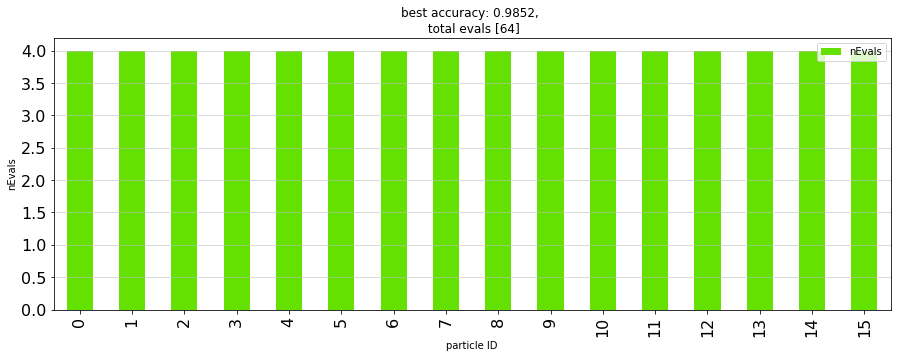

In [34]:
sortedBarHeightsDF = swarm.plot_eval_distribution ( particleHistory,  globalBest['particleID'] );


In [35]:
swarm.viz_particle_movement( particleHistory )

## Launch **Asynchronous** Particle Swarm
> i.e., particles update their location in hyper-parameter space as soon as their previous evaluation is complete

> note it is possible that particles will query a stale version of the global best, but in practice this is inconsequential given the performance gain

In [36]:
mode = {'allowAsyncUpdates': True, 'randomSearch': False }
particleHistoryAsync, globalBestAsync, elapsedTime = run_hpo ( client, mode, nParticles, nEpochs, paramRanges, 
                                                     trainData_cDF, trainLabels_cDF, testData_cDF, testLabels_cDF, 
                                                     wMomentum = .05, wIndividual = .25, wBest = .45, wExplore = 0,
                                                     plotFlag = False, 
                                                     retainPredictionsFlag = True )

0.983413 -- new global best by particle: 10, eval: 0, params: 6, 0.3387, 0.6344, 84
   - new personal best for particle 10, 0.9834, params: 6, 0.3387, 0.6344, 84
   - new personal best for particle 8, 0.9820, params: 3, 0.3643, 0.8772, 257
   - new personal best for particle 3, 0.9825, params: 8, 0.8701, 1.5983, 18
   - new personal best for particle 12, 0.9829, params: 6, 0.9768, 1.4785, 44
0.984713 -- new global best by particle: 15, eval: 4, params: 4, 0.2784, 1.6847, 296
   - new personal best for particle 15, 0.9847, params: 4, 0.2784, 1.6847, 296
   - new personal best for particle 10, 0.9846, params: 6, 0.3561, 0.6901, 98
   - new personal best for particle 8, 0.9843, params: 4, 0.3602, 0.8691, 194
   - new personal best for particle 2, 0.9784, params: 17, 0.9257, 0.1743, 4
   - new personal best for particle 12, 0.9846, params: 5, 0.6072, 1.2939, 62
0.984925 -- new global best by particle: 8, eval: 12, params: 4, 0.3243, 1.2241, 182
   - new personal best for particle 8, 0.9849

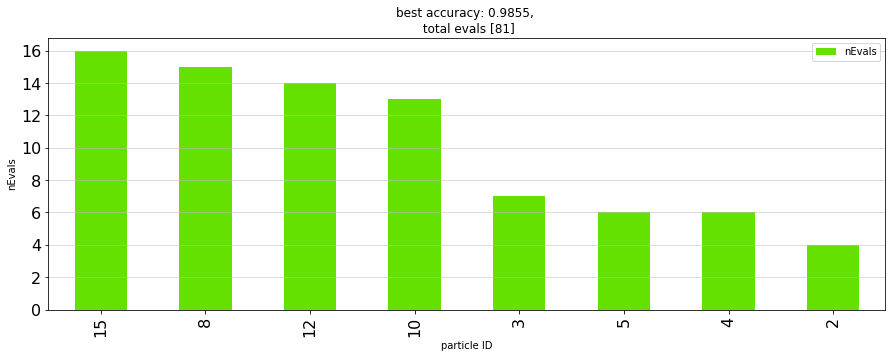

In [37]:
sortedBarHeightsDF = swarm.plot_eval_distribution ( particleHistoryAsync,  globalBestAsync['particleID'] );

In [38]:
swarm.viz_particle_movement( particleHistoryAsync )

## Launch Baseline -- **Asynchronous Random Search**

In [ ]:
mode = {'allowAsyncUpdates': True, 'randomSearch': True }
particleHistoryBaseline, globalBestBaseline, _ = run_hpo ( client, mode, nParticles, nEpochs, paramRanges, 
                                                           trainData_cDF, trainLabels_cDF, testData_cDF, testLabels_cDF, 
                                                           wMomentum = .05, wIndividual = .25, wBest = .45, wExplore = 0, 
                                                           plotFlag = False, 
                                                           retainPredictionsFlag = True )

0.983262 -- new global best by particle: 11, eval: 0, params: 6, 0.8212, 1.6759, 82
random-search-mode : skipping updates to personal best
random-search-update: params [7.         0.43381578 0.3616491 ] velos: [ 6.66624312 -0.80154919 -1.39752778]
random-search-mode : skipping updates to personal best
random-search-update: params [12.          0.49509534  1.66382272] velos: [-6.84212084 -0.11385613  0.33328695]
0.984012 -- new global best by particle: 9, eval: 2, params: 7, 0.6354, 1.1637, 60
random-search-mode : skipping updates to personal best
random-search-update: params [1.30000000e+01 4.25303403e-01 7.08119463e-04] velos: [ 9.81177327 -0.04221845  1.42546818]
0.984725 -- new global best by particle: 11, eval: 3, params: 7, 0.4338, 0.3616, 32
random-search-mode : skipping updates to personal best
random-search-update: params [7.         0.43381578 0.3616491 ] velos: [ 6.66624312 -0.80154919 -1.39752778]
random-search-mode : skipping updates to personal best
random-search-update: p

In [ ]:
sortedBarHeightsDF = swarm.plot_eval_distribution ( particleHistoryBaseline,  globalBestBaseline['particleID'] );

In [ ]:
swarm.viz_particle_movement( particleHistoryBaseline )